# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f595c562f50>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
num_samples = len(test_dataloader.dataset)
print(num_samples)

75


### Get and prepare a pretrained model

In [ ]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(model_0,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width) WHY
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 9.290 seconds


### Make predictions on the entire test dataset with the model

In [ ]:
# TODO

from tqdm.auto import tqdm
y_pred = []
y_true = []
y_probab = []

model_0.eval()
with torch.inference_mode():

    for batch, (X, y) in enumerate(test_dataloader):

        X, y = X.to(device), y.to(device)
        test_pred_logits = model_0(X)
        test_pred_probab, _ = torch.softmax(test_pred_logits, dim = 1).max(dim = 1)   #torch.softmax(test_pred_logits, dim=1).max(dim=1) returns a tuple where the first element is the maximum value (probability) and the second element is the index of the maximum value. We only need the maximum value, so we use test_pred_probab, _ to unpack it.
        test_pred_labels = test_pred_logits.argmax(dim=1)
        y_pred.append(test_pred_labels.cpu())
        y_probab.append(test_pred_probab.cpu())
        y_true.append(y.cpu())


y_pred_tensor = torch.cat(y_pred)
y_probab_tensor = torch.cat(y_probab)
y_true_tensor = torch.cat(y_true)  #done because there is no test_dataset, directly as we had a create_dataloader function




### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.9 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [ ]:
class_names

['pizza', 'steak', 'sushi']

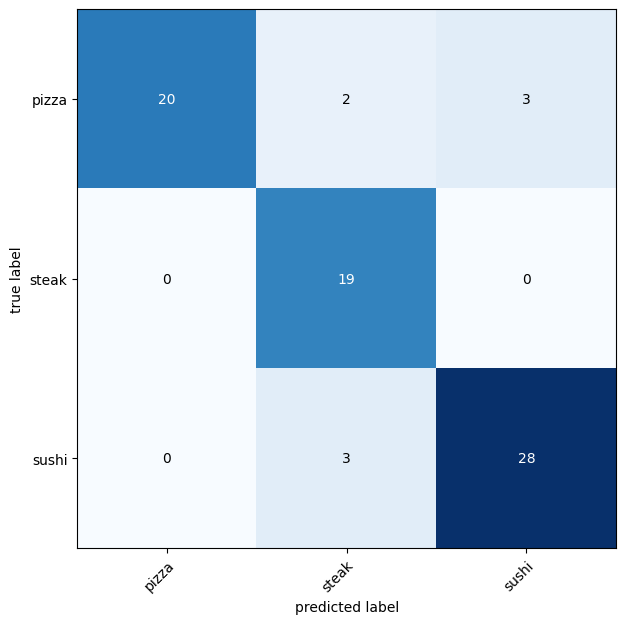

In [ ]:
# TODO

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target= y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);



## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [ ]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]   ## Get all paths and labels

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path


    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))    # Output shape is (batch_size, class_numbers)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]


      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()   #.item() extracts the scalar value from the tensor. This is essential because in PyTorch, operations often return tensors, even if they contain a single value.
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.46612709760665894,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7782352566719055,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6940959692001343,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.42687371373176575,
  'pred_class': 'sushi',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7349491119384766,
  'pred_class': 'pizza',
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
53   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.546966   
70  data/pizza_steak_sushi/test/sushi/1172255.jpg      sushi   0.449595   
19   data/pizza_steak_sushi/test/pizza/971934.jpg      pizza   0.444701   
18  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza   0.435138   
3    data/pizza_steak_sushi/test/pizza/309892.jpg      pizza   0.426874   

   pred_class  correct  
53      steak    False  
70      steak    False  
19      sushi    False  
18      sushi    False  
3       sushi    False

We only imported datas_setup and engine from going modular

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def plot_image(  image_path: str, class_name: str, pred_class : str, pred_prob: float, device: torch.device=device):

    img = Image.open(image_path)


    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {pred_class} | Prob: {pred_prob} | True:{class_name} ")
    plt.axis(False)



53    None
70    None
19    None
18    None
3     None
dtype: object

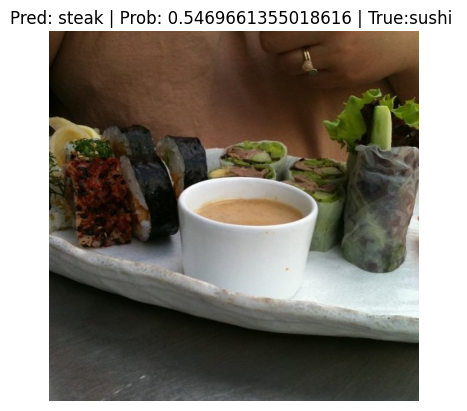

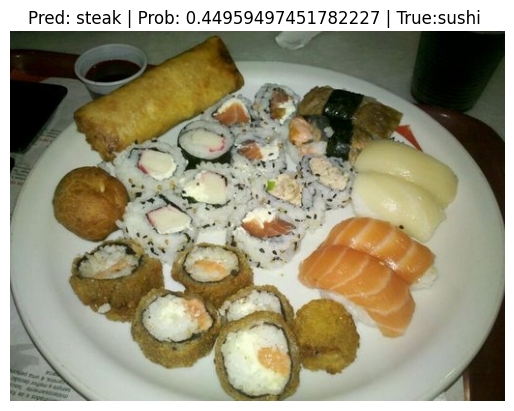

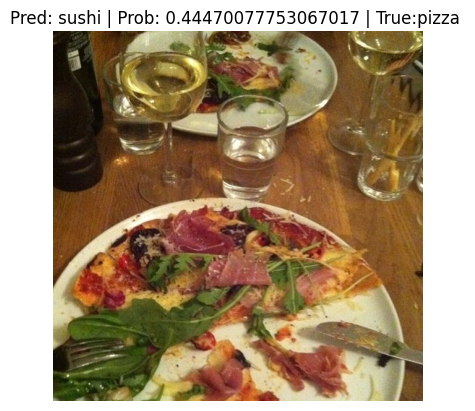

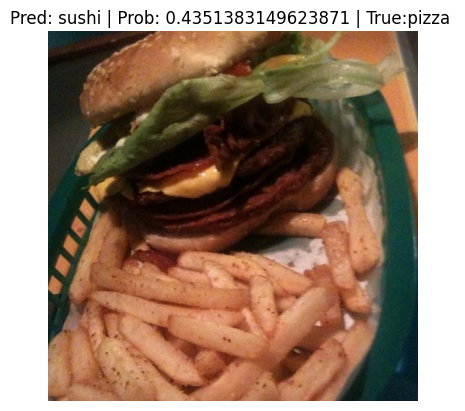

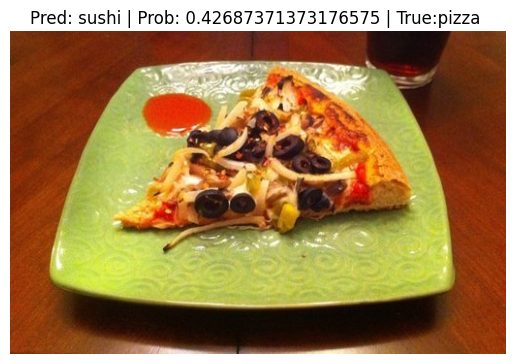

In [ ]:
top_5_most_wrong.apply(lambda row: plot_image(row['image_path'], row['class_name'], row['pred_class'], row['pred_prob']), axis=1)

OR:

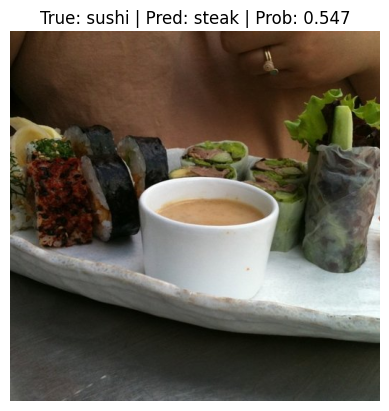

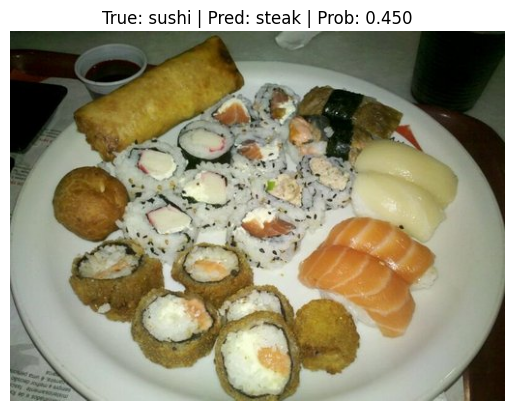

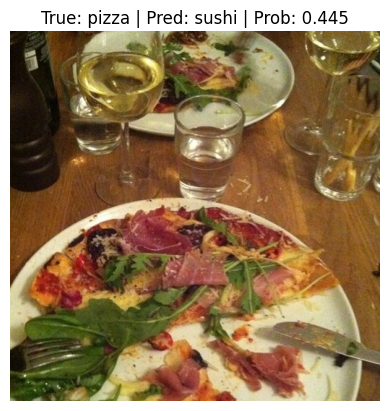

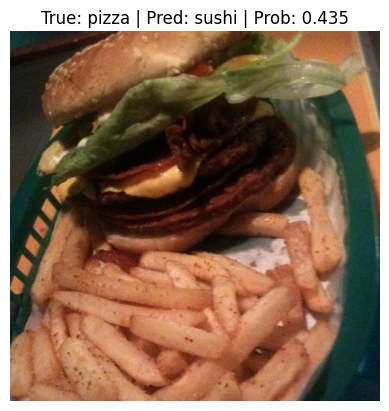

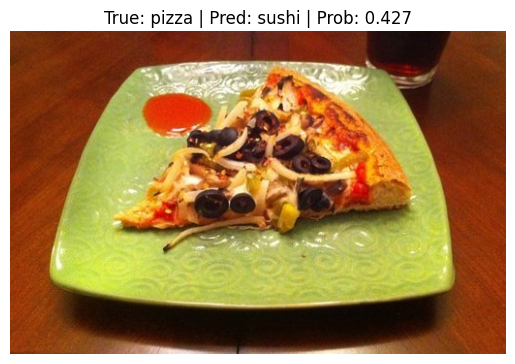

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

data/pizza_unsplash already exists, skipping download.


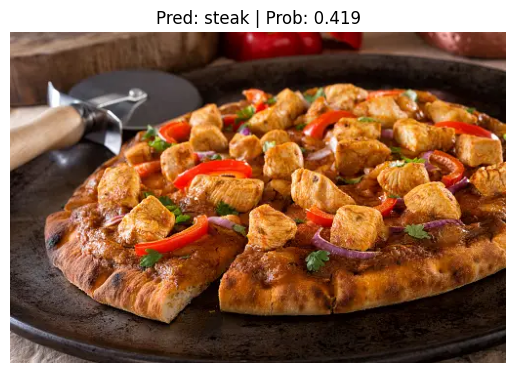

In [ ]:
# TODO: Get an image of pizza/steak/sushi
import requests

# Setup custom image path
custom_image_path = data_path / "pizza_unsplash"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://media.istockphoto.com/id/1043604390/photo/butter-chicken-pizza.webp?b=1&s=170667a&w=0&k=20&c=Wym829QYZPqR8WyxuKlzJnkQuhn2F-CnPPDh7JakPqA=")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names, transform  = simple_transform)

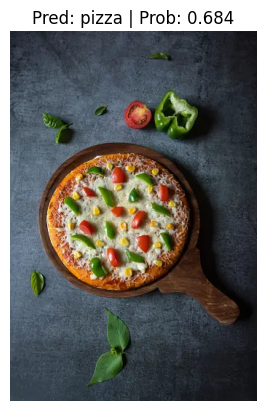

In [ ]:
import requests

# Setup custom image path
custom_image_path = data_path / "pizza_unsplash2"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://media.istockphoto.com/id/1287894191/photo/vertical-top-view-of-margherita-pizza-with-vegetables-and-herbs.webp?b=1&s=170667a&w=0&k=20&c=9Kfay5vXZj8idcTws9i8C35TUx0xhtC9Kzduv8i7ab0=")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names, transform = simple_transform)

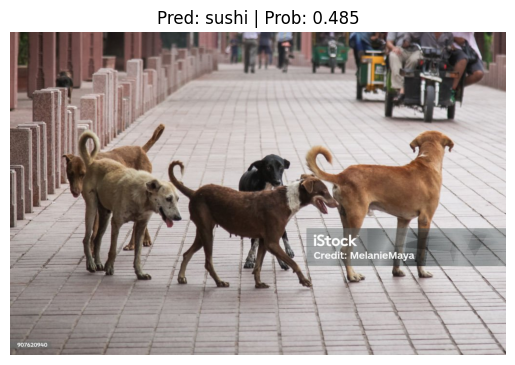

In [ ]:
# TODO: Get an image of not pizza/steak/sushi
import requests

# Setup custom image path
custom_image_path = data_path / "dog"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://media.istockphoto.com/id/907620940/photo/street-dog-family-in-india.jpg?s=1024x1024&w=is&k=20&c=-hU4FDU2Vtm8Nrfg-v2InstJnRPnsE5XCLBmOoycmJA=")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names, transform = simple_transform)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model
# TODO: Recreate a new model
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False
    # Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


In [ ]:
# TODO: Train the model for 10 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
[INFO] Total training time: 36.663 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f59551ae230>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [ ]:
# TODO
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False
    # Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)


### Train a model with 20% of the data

In [ ]:
# TODO
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4271 | train_acc: 0.8396 | test_loss: 0.3534 | test_acc: 0.9006
Epoch: 7 | train_loss: 0.4157 | train_acc: 0.8396 | test_loss: 0.3159 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3935 | train_acc: 0.8500 | test_loss: 0.3192 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3163 | train_acc: 0.8938 | test_loss: 0.3025 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3488 | train_acc: 0.9042 | test_loss: 0.2699 | test_acc: 0.9318
[INFO] Total training time: 33.675 seconds


If we use auto_trasforms:

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

auto_transforms = weights.transforms()
auto_transforms

In [ ]:
train_dataloader_20_percent_at, test_dataloader_20_percent_at, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent_at, test_dataloader_20_percent_at, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f58a829e080>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
model_2_at = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2_at.features.parameters():
    param.requires_grad = False
    # Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2_at.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2_at.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_at_results = engine.train(model=model_2_at,
                       train_dataloader=train_dataloader_20_percent_at,
                       test_dataloader=test_dataloader_20_percent_at,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9784 | train_acc: 0.5583 | test_loss: 0.6719 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7148 | train_acc: 0.8167 | test_loss: 0.5588 | test_acc: 0.8727
Epoch: 3 | train_loss: 0.6047 | train_acc: 0.7937 | test_loss: 0.4808 | test_acc: 0.8915
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.9000 | test_loss: 0.4338 | test_acc: 0.8756
Epoch: 5 | train_loss: 0.4566 | train_acc: 0.8812 | test_loss: 0.4090 | test_acc: 0.8858
Epoch: 6 | train_loss: 0.4367 | train_acc: 0.8812 | test_loss: 0.3729 | test_acc: 0.9068
Epoch: 7 | train_loss: 0.4260 | train_acc: 0.8458 | test_loss: 0.3458 | test_acc: 0.9097
Epoch: 8 | train_loss: 0.4209 | train_acc: 0.8479 | test_loss: 0.3594 | test_acc: 0.8642
Epoch: 9 | train_loss: 0.3432 | train_acc: 0.8729 | test_loss: 0.3190 | test_acc: 0.9165
Epoch: 10 | train_loss: 0.3720 | train_acc: 0.8750 | test_loss: 0.3107 | test_acc: 0.8915
[INFO] Total training time: 52.881 seconds


In [ ]:
model_2_new_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent_at,
                       test_dataloader=test_dataloader_20_percent_at,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1101 | train_acc: 0.3688 | test_loss: 1.0957 | test_acc: 0.3602
Epoch: 2 | train_loss: 1.1172 | train_acc: 0.3083 | test_loss: 1.1006 | test_acc: 0.3631
Epoch: 3 | train_loss: 1.1169 | train_acc: 0.3229 | test_loss: 1.0956 | test_acc: 0.3511
Epoch: 4 | train_loss: 1.1073 | train_acc: 0.3167 | test_loss: 1.0963 | test_acc: 0.3665
Epoch: 5 | train_loss: 1.1105 | train_acc: 0.3146 | test_loss: 1.0901 | test_acc: 0.3665
Epoch: 6 | train_loss: 1.1225 | train_acc: 0.3292 | test_loss: 1.0984 | test_acc: 0.3540
Epoch: 7 | train_loss: 1.1183 | train_acc: 0.3604 | test_loss: 1.0926 | test_acc: 0.3540
Epoch: 8 | train_loss: 1.1078 | train_acc: 0.3583 | test_loss: 1.0944 | test_acc: 0.3420
Epoch: 9 | train_loss: 1.1205 | train_acc: 0.3396 | test_loss: 1.0942 | test_acc: 0.3540
Epoch: 10 | train_loss: 1.1044 | train_acc: 0.3563 | test_loss: 1.0908 | test_acc: 0.3727


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
auto_transforms_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()


In [ ]:
auto_transforms_b2

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader_20_percent_b2, test_dataloader_20_percent_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transforms_b2, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32
train_dataloader_20_percent_b2, test_dataloader_20_percent_b2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f58b22aa620>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
for inputs, labels in train_dataloader:
    print(f'Input batch shape: {inputs.shape}')
    print(f'Label batch shape: {labels.shape}')
    break  # Only check the first batch

Input batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [ ]:
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False
    # Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features= 1408,      #classfier layer takes in 1408 features
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
# TODO
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader_20_percent_b2,
                       test_dataloader=test_dataloader_20_percent_b2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9455 | train_acc: 0.6000 | test_loss: 0.7057 | test_acc: 0.9472
Epoch: 2 | train_loss: 0.6706 | train_acc: 0.8646 | test_loss: 0.5655 | test_acc: 0.9597
Epoch: 3 | train_loss: 0.5610 | train_acc: 0.9021 | test_loss: 0.4692 | test_acc: 0.9534
Epoch: 4 | train_loss: 0.4277 | train_acc: 0.9062 | test_loss: 0.4142 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.4091 | train_acc: 0.8958 | test_loss: 0.3776 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.4294 | train_acc: 0.8938 | test_loss: 0.3368 | test_acc: 0.9659
Epoch: 7 | train_loss: 0.4164 | train_acc: 0.8750 | test_loss: 0.3139 | test_acc: 0.9597
Epoch: 8 | train_loss: 0.3843 | train_acc: 0.8979 | test_loss: 0.3383 | test_acc: 0.9386
Epoch: 9 | train_loss: 0.3679 | train_acc: 0.8917 | test_loss: 0.2992 | test_acc: 0.9381
Epoch: 10 | train_loss: 0.3454 | train_acc: 0.8646 | test_loss: 0.2702 | test_acc: 0.9563
[INFO] Total training time: 66.858 seconds


In [ ]:
simple_transforms_2 = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229,  0.224, 0.225] (across each colour channel),
])

In [ ]:
train_dataloader_20_percent_b2_st, test_dataloader_20_percent_b2_st, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transforms_b2, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32
train_dataloader_20_percent_b2_st, test_dataloader_20_percent_b2_st, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5929e53370>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
model_3_st = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False
    # Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3_st.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features= 1408,      #classfier layer takes in 1408 features
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3_st.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_st_results = engine.train(model=model_3_st,
                       train_dataloader=train_dataloader_20_percent_b2_st,
                       test_dataloader=test_dataloader_20_percent_b2_st,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4464 | train_acc: 0.8667 | test_loss: 0.1183 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.2923 | train_acc: 0.8958 | test_loss: 0.3056 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.3095 | train_acc: 0.9271 | test_loss: 0.1553 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.1923 | train_acc: 0.9187 | test_loss: 0.1644 | test_acc: 0.9313
Epoch: 5 | train_loss: 0.1903 | train_acc: 0.9375 | test_loss: 0.2208 | test_acc: 0.9381
Epoch: 6 | train_loss: 0.2356 | train_acc: 0.9250 | test_loss: 0.3237 | test_acc: 0.8415
Epoch: 7 | train_loss: 0.2429 | train_acc: 0.9396 | test_loss: 0.0817 | test_acc: 0.9659
Epoch: 8 | train_loss: 0.4688 | train_acc: 0.9000 | test_loss: 0.3491 | test_acc: 0.8795
Epoch: 9 | train_loss: 0.3445 | train_acc: 0.8938 | test_loss: 0.1630 | test_acc: 0.9443
Epoch: 10 | train_loss: 0.2227 | train_acc: 0.9250 | test_loss: 0.2475 | test_acc: 0.9443
[INFO] Total training time: 81.158 seconds
